In [33]:
import numpy as np
import pandas as pd
from pathlib import Path

In [34]:
data_path = Path().cwd().parents[0] / 'data'

assert data_path.is_dir()

samples = [i for i in sorted(data_path.iterdir())]
print(f'Samples in data: {len(samples)}')

Samples in data: 718


In [35]:
periods = ['1_hour', '2_hour', '4_hour', '6_hour', '12_hour', '7_day']
ticker_types = ['bitcoin', 'eth']
source_types = ['comments', 'threads']
source_attrs = ['hot', 'new'] 

prepared_columns = []

for ticker in ticker_types:
    for period in periods:
        for source_type in source_types:
            for source_attr in source_attrs:
                prepared_columns.append('_'.join((source_attr, ticker, source_type, period)))

df_sentiment_simple = pd.DataFrame(columns=['date', *prepared_columns])
df_sentiment_hype = pd.DataFrame(columns=['date', *prepared_columns])

In [36]:
def MatchSentimentFileToColumn(filename):
    tokens = filename.split('_')
    return '_'.join([tokens[0], tokens[1], tokens[2], tokens[4], tokens[5]])

In [37]:
from sklearn.preprocessing import StandardScaler


def CalculateSentimentSimpleIndex(sentiment_file):
    try:
        sentiment_df = pd.read_csv(sentiment_file, sep=',', engine='python')
    except Exception as err:
        print(f'Cannot parse {sentiment_file}')
        return 0

    if len(sentiment_df) == 0:
        return 0
    sentiment_df['score'] = StandardScaler().fit_transform(sentiment_df[['score']])
    sentiment_df['result'] = sentiment_df['score'] * sentiment_df['compound']
    return sentiment_df['result'].sum()


def CalculateSentimentHypeIndex(sentiment_file, prev_all):
    try:
        sentiment_df = pd.read_csv(sentiment_file, sep=',', engine='python')
    except Exception as err:
        print(f'Cannot parse {sentiment_file}')
        return 0

    if prev_all == 0:
        return 0, len(sentiment_df)
    
    if len(sentiment_df) == 0:
        return 0, 0

    sentiment_df['score'] = StandardScaler().fit_transform(sentiment_df[['score']])
    sentiment_df['temp'] = sentiment_df['score'] * sentiment_df['compound']
    positive = sentiment_df[sentiment_df['temp'] > 0].all().sum()
    all = len(sentiment_df)
    return ((positive / all) * ((all / prev_all) - 1), all)


count = 0

prev_all_map = {}

for sample in samples:
    row_simple_index = {'date' : sample.name}
    row_hype_index = {'date' : sample.name}

    for sentiment_file in sample.iterdir():
        row_name = MatchSentimentFileToColumn(sentiment_file.name)

        # Simple sentiment index
        row_simple_index[row_name] = CalculateSentimentSimpleIndex(sentiment_file)

        # Hype index
        prev_all = 0
        if row_name in prev_all_map:
            prev_all = prev_all_map[row_name]
        hype_index, all = CalculateSentimentHypeIndex(sentiment_file, prev_all)
        row_hype_index[row_name] = hype_index
        prev_all_map[row_name] = all
    
    df_sentiment_simple = df_sentiment_simple._append(row_simple_index, ignore_index = True)
    df_sentiment_hype = df_sentiment_hype._append(row_hype_index, ignore_index = True)
    
    count += 1
    if count % 25 == 0 and count > 0:
        print(f'Processed {count} of {len(samples)}')

/tmp/ipykernel_457942/149672394.py:60: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_sentiment_simple = df_sentiment_simple._append(row_simple_index, ignore_index = True)


Processed 25 of 718
Processed 50 of 718
Processed 75 of 718
Processed 100 of 718
Processed 125 of 718
Processed 150 of 718
Processed 175 of 718
Processed 200 of 718
Processed 225 of 718
Processed 250 of 718
Processed 275 of 718
Processed 300 of 718
Processed 325 of 718
Processed 350 of 718
Processed 375 of 718
Processed 400 of 718
Processed 425 of 718
Processed 450 of 718
Processed 475 of 718
Processed 500 of 718
Processed 525 of 718
Processed 550 of 718
Processed 575 of 718
Processed 600 of 718
Processed 625 of 718
Processed 650 of 718
Processed 675 of 718
Processed 700 of 718


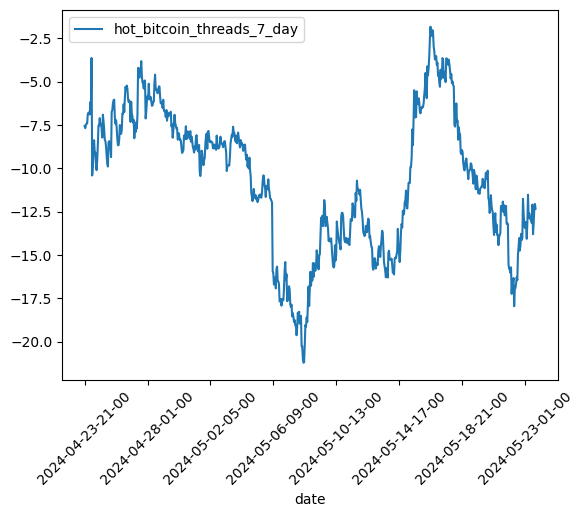

In [38]:
import matplotlib.pyplot as plt

df_sentiment_simple.plot(kind = 'line', x = 'date', y = 'hot_bitcoin_threads_7_day')
plt.xticks(rotation=45)
plt.show()

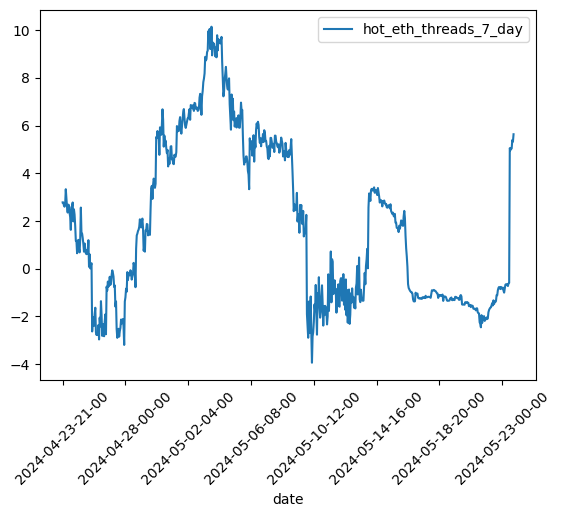

In [31]:
df_sentiment_simple.plot(kind = 'line', x = 'date', y = 'hot_eth_threads_7_day')
plt.xticks(rotation=45)
plt.show()

In [53]:
df_sentiment_hype.to_csv('/home/maximbasalaev/Desktop/hype_index.csv')
df_sentiment_simple.to_csv('/home/maximbasalaev/Desktop/simple_index.csv')